In [1]:
!pip install mediapipe==0.10.14

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.7 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.7 which is incompatible.


In [2]:
import itertools
import kagglehub
import os
import cv2
import numpy as np
import glob
import shutil
import pandas as pd
import dlib
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import zip_longest
from glob import glob
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from skimage import exposure
import cv2
import os
import numpy as np
import mediapipe as mp
import pywt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import kagglehub
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import to_categorical
import warnings; warnings.simplefilter('ignore')

## Detectem cara MediaPipe's

In [5]:
mp_face_mesh = mp.solutions.face_mesh

def extract_mouth_mp(image):
    """
    Detects mouth using MediaPipe FaceMesh and extracts HOG features.
    """
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True) as face_mesh:
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(img_rgb)

        if not results.multi_face_landmarks:
            return None

        landmarks = results.multi_face_landmarks[0].landmark

        # Indices for mouth region (similar to dlib 48-67)
        mouth_indices = list(range(61, 88))  # Inner + outer lips (approximated)
        h, w = image.shape[:2]

        mouth_points = [(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in mouth_indices]

        mouth_np = np.array(mouth_points)
        x, y, mw, mh = cv2.boundingRect(mouth_np)

        mouth_roi = image[y:y+mh, x:x+mw]
        if mouth_roi.size == 0:
            return None

        # Convert to grayscale and extract HOG
        # Convert to grayscale only if it's a color image
        if len(mouth_roi.shape) == 3 and mouth_roi.shape[2] == 3:
            gray_mouth = cv2.cvtColor(mouth_roi, cv2.COLOR_BGR2GRAY)
        else:
            gray_mouth = mouth_roi

        resized = cv2.resize(gray_mouth, (64, 64))
        features = hog(resized, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)

        return features


### Carreguem FER 2013

In [6]:
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fer2013


Train amb 3 possibles models

In [7]:
def train(model, train_dir, emotions):
    X_train, y_train = [], []

    for emotion in emotions:
        emotion_path = os.path.join(train_dir, emotion)
        files = sorted(os.listdir(emotion_path))

        for filename in files:
            img_path = os.path.join(emotion_path, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            features = extract_mouth_mp(gray)

            if features is not None:
                X_train.append(features)
                y_train.append(emotion)

    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)

    if model == 'rf':
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
    elif model == 'knn':
        clf = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
    elif model == 'svm':
        clf = SVC(kernel='linear', probability=True)
    else:
        raise ValueError("Model not available")

    clf.fit(X_train, y_train_enc)

    # Save model and label encoder
    with open(f'emotion_{model}.pkl', 'wb') as f:
        pickle.dump((clf, le), f)

    print(f"Model '{model}' trained on {len(X_train)} samples.")


Test

In [8]:
def test(model, test_dir, emotions):
    try:
        with open(f'emotion_{model}.pkl', 'rb') as f:
            clf, le = pickle.load(f)
    except FileNotFoundError:
        print(f"Model file for '{model}' not found. Please train first.")
        return

    y_true, y_pred = [], []

    for emotion in emotions:
        emotion_path = os.path.join(test_dir, emotion)
        files = sorted(os.listdir(emotion_path))

        for filename in files:
            img_path = os.path.join(emotion_path, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            features = extract_mouth_mp(gray)

            if features is not None:
                pred = clf.predict([features])[0]
                pred_label = le.inverse_transform([pred])[0]
                y_true.append(emotion)
                y_pred.append(pred_label)
    print(f"\nResults with model '{model}':\n")
    print(classification_report(y_true, y_pred, zero_division=0))

    cm = confusion_matrix(y_true, y_pred, labels=emotions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model.upper()} Confusion Matrix')
    plt.tight_layout()
    plt.show()


Prova KNN

In [ ]:
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
train_dir = os.path.join(path, 'train')
test_dir = os.path.join(path, 'test')

train(model='knn', train_dir=train_dir, emotions=emotions)
test(model='knn', test_dir=test_dir, emotions=emotions)


Prova Random Foresr

Model 'rf' trained on 24709 samples.

Results with model 'rf':

              precision    recall  f1-score   support

       angry       0.51      0.24      0.33       772
     disgust       1.00      0.31      0.47        91
        fear       0.47      0.22      0.30       882
       happy       0.55      0.85      0.67      1604
     neutral       0.40      0.58      0.47      1134
         sad       0.39      0.28      0.32      1018
    surprise       0.75      0.57      0.65       730

    accuracy                           0.50      6231
   macro avg       0.58      0.44      0.46      6231
weighted avg       0.51      0.50      0.48      6231



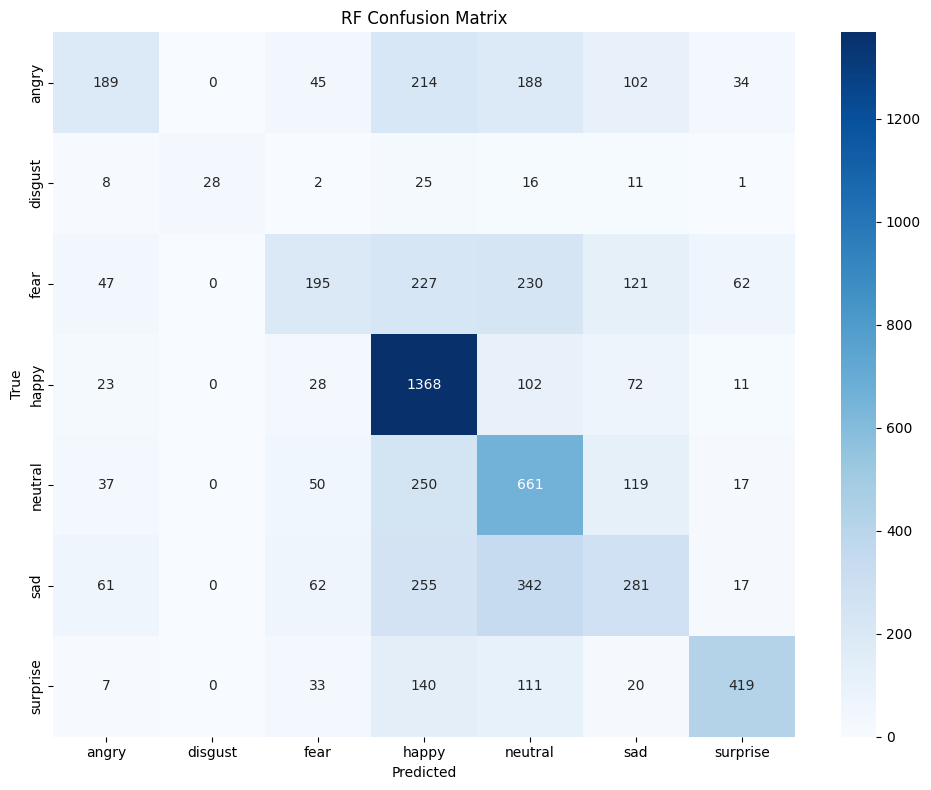

In [17]:
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
train_dir = os.path.join(path, 'train')
test_dir = os.path.join(path, 'test')

train(model='rf', train_dir=train_dir, emotions=emotions)
test(model='rf', test_dir=test_dir, emotions=emotions)


Prova Support Vector Classifier (Support Vector Machine)

Model 'svm' trained on 24709 samples.

Results with model 'svm':

              precision    recall  f1-score   support

       angry       0.37      0.40      0.38       772
     disgust       0.49      0.32      0.39        91
        fear       0.33      0.26      0.29       882
       happy       0.68      0.76      0.72      1604
     neutral       0.45      0.50      0.47      1134
         sad       0.33      0.29      0.31      1018
    surprise       0.64      0.58      0.61       730

    accuracy                           0.49      6231
   macro avg       0.47      0.44      0.45      6231
weighted avg       0.48      0.49      0.49      6231



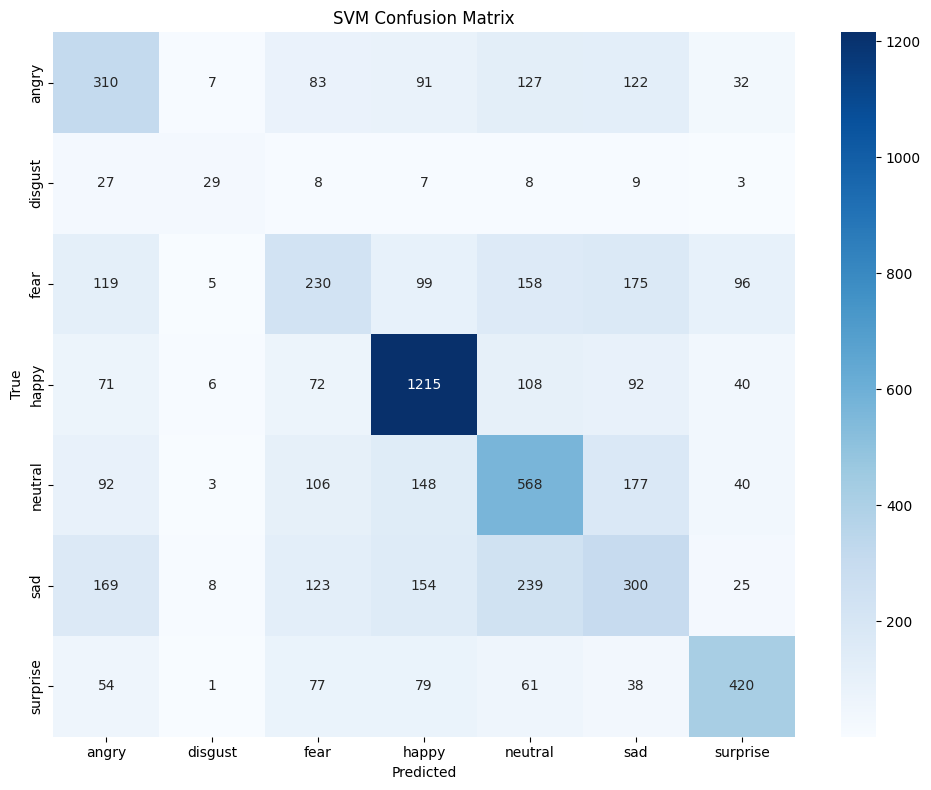

In [9]:
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
train_dir = os.path.join(path, 'train')
test_dir = os.path.join(path, 'test')

train(model='svm', train_dir=train_dir, emotions=emotions)
test(model='svm', test_dir=test_dir, emotions=emotions)


## Carrreguem Facial emotion Recognition

In [ ]:
source_dir = kagglehub.dataset_download("tapakah68/facial-emotion-recognition")
people_dirs = glob(os.path.join(source_dir+'/images', "*"))

# Path al dataset organitzat
dest_dir = "/kaggle/working/organized_by_emotion"
os.makedirs(dest_dir, exist_ok=True)

# Possibles emocions
emotions = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprised', 'Neutral', 'Contempt']

# Organitzem emocions per carpetes
for emotion in emotions:
    os.makedirs(os.path.join(dest_dir, emotion), exist_ok=True)


# Movem les emocions a les carpetes
for person_path in people_dirs:
    if os.path.isdir(person_path):
        person_id = os.path.basename(person_path)
        emotion_images = glob(os.path.join(person_path, "*.jpg"))

        for img_path in emotion_images:
            emotion = os.path.splitext(os.path.basename(img_path))[0].capitalize()
            if emotion in emotions:
                new_filename = f"{person_id}.jpg"
                dest_path = os.path.join(dest_dir, emotion, new_filename)
                shutil.copy(img_path, dest_path)